In [ ]:
import numpy as np
import yfinance as yf
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from sklearn.preprocessing import MinMaxScaler, RobustScaler
import pandas as pd
from collections import deque
import os
from google.colab import drive
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from itertools import product
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preprocessing

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/MergedDataSectorPrognosis.xlsx')
economicData = pd.read_excel('/content/drive/MyDrive/EconomicDataforModel.xlsx', sheet_name='FullData')

df = df.loc[:, ~df.columns.str.startswith('Energy')].copy()
df = df.loc[:, ~df.columns.str.startswith('Communications')].copy()
df = df.loc[:, ~df.columns.str.startswith('IT')].copy()



df["Date"] = pd.to_datetime(df["Date"])
economicData["Date"] = pd.to_datetime(economicData["Date"])
merged_df = pd.merge(df, economicData, on="Date", how="inner")
merged_df = merged_df.dropna()

targets = 6

merged_df = merged_df.dropna()
month = np.float32(df["Date"].dt.month / 12)
merged_df.insert(targets+1, "Month", month)
merged_df = merged_df.drop(columns=["Date"])
print(merged_df.head())



   HealthCare  Materials  Industrials  ConsumerStaples  ConsumerDiscretionary  \
0     4609.52     529.77      1115.65           853.65              1831.1637   
1     4657.95     527.90      1117.17           852.53              1849.3140   
2     4709.40     535.06      1128.17           862.90              1879.2100   
3     4780.84     538.15      1137.39           867.98              1915.5290   
4     4777.09     539.13      1136.69           867.68              1927.8730   

   Utilities  Month  HealthCare Performance  Materials Performance  \
0     384.95    1.0                0.231673               0.360972   
1     385.42    1.0                0.270584               0.352868   
2     386.91    1.0                0.303174               0.366967   
3     388.04    1.0                0.322908               0.368594   
4     389.10    1.0                0.330797               0.374975   

   Industrials Performance  ...  UnemploymentRate  CPI  CoreCPI  CorePCE  PPI  \
0          

In [ ]:
arr = merged_df.values

scaler = MinMaxScaler()
scaled_arr = scaler.fit_transform(arr[:, targets:])


pca = PCA(n_components=21)  # > 95% variance
pca_result = pca.fit_transform(scaled_arr)

timeframe = 250 #equivalent to one year in the data
offsets = np.array([timeframe, int(timeframe * 13/12), int(timeframe * 5/4), int(timeframe * 3/2), int(timeframe * 2)])
print(offsets)

x = []
y = []

for i in range(len(arr) - (max(offsets))):
    current = arr[i]
    reference_points = np.array([np.array(pca_result[i + offset]) for offset in offsets])
    y.append((arr[i][:targets] - arr[i+timeframe][:targets]) / arr[i+timeframe][:targets])
    x.append(np.concatenate(reference_points))

x = np.array(x, dtype=np.float32)
y = np.array(y, dtype=np.float32)

x = np.array(x, dtype=np.float32)
y = np.array(y, dtype=np.float32)


n = int(len(x) * 0.1)


xte = x[:n]
yte = y[:n]
xval = x[n:n+n]
yval = y[n:n+n]
xtr = x[n+n:]
ytr = y[n+n:]


xtr = torch.from_numpy(xtr).float()
ytr = torch.from_numpy(ytr).float()
xval = torch.from_numpy(xval).float()
yval = torch.from_numpy(yval).float()
xte = torch.from_numpy(xte).float()
yte = torch.from_numpy(yte).float()

print(xtr.shape)
print(ytr.shape)
print(xval.shape)
print(yval.shape)
print(xte.shape)
print(yte.shape)


[250 270 312 375 500]
torch.Size([4440, 105])
torch.Size([4440, 6])
torch.Size([555, 105])
torch.Size([555, 6])
torch.Size([555, 105])
torch.Size([555, 6])


# Model Architecture

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ResidualBlock, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        self.linear = nn.Linear(input_size, hidden_size)
        nn.init.kaiming_uniform_(self.linear.weight, mode='fan_in', nonlinearity='relu')
        self.linear.bias.data.zero_()
        self.bn = nn.BatchNorm1d(hidden_size)
        self.dropout = nn.Dropout(p=0.3)
        self.relu = nn.ReLU()

        self.projection = None
        if input_size != hidden_size:
            self.projection = nn.Linear(input_size, hidden_size)

    def forward(self, x):
        residual = x
        out = self.linear(x)
        out = self.bn(out)
        out = self.dropout(out)
        out = self.relu(out)

        # Apply projection if input and hidden sizes differ
        if self.projection:
            residual = self.projection(residual)

        # residual connection
        out = out + residual
        return out

class Net(nn.Module):
    def __init__(self, input_size, hidden_size=256, num_hid_layers=5):
        super(Net, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(num_hid_layers):
            if i == 0:
                self.layers.append(ResidualBlock(input_size, hidden_size))
            else:
                self.layers.append(ResidualBlock(hidden_size, hidden_size))

        self.output_layer = nn.Linear(hidden_size, targets)
        with torch.no_grad():
            self.output_layer.weight *= 0.1
            if self.output_layer.bias is not None:
              self.output_layer.bias.zero_()

    def forward(self, x):

        for layer in self.layers:
            x = layer(x)

        return self.output_layer(x)

    def predict(self, x):
        with torch.no_grad():
            out = self.forward(x)
        return out

# Grid Search and Training


Training combination 1/18
Parameters: lr=0.0001, hidden_size=256, num_hid_layers=3


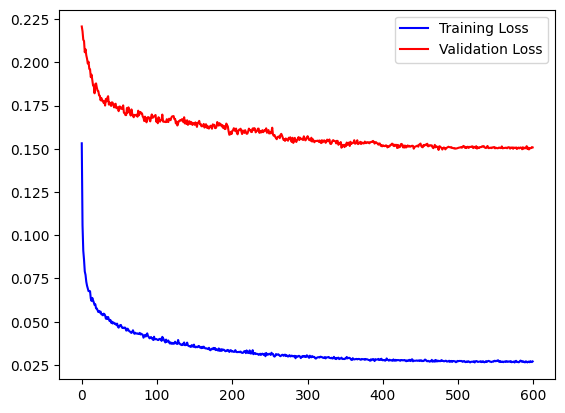

Average R² Score: 0.2322

Training combination 2/18
Parameters: lr=0.0001, hidden_size=256, num_hid_layers=4


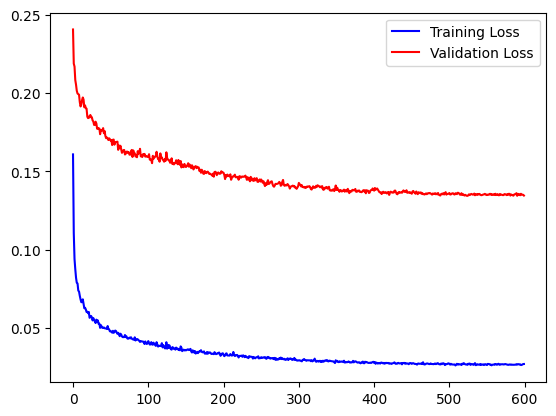

Average R² Score: 0.3074

Training combination 3/18
Parameters: lr=0.0001, hidden_size=256, num_hid_layers=5


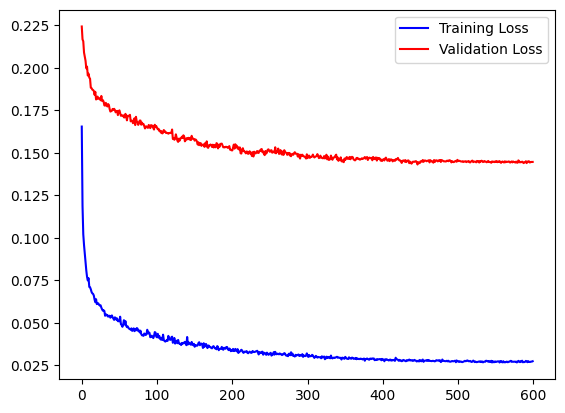

Average R² Score: 0.3390

Training combination 4/18
Parameters: lr=0.0001, hidden_size=512, num_hid_layers=3


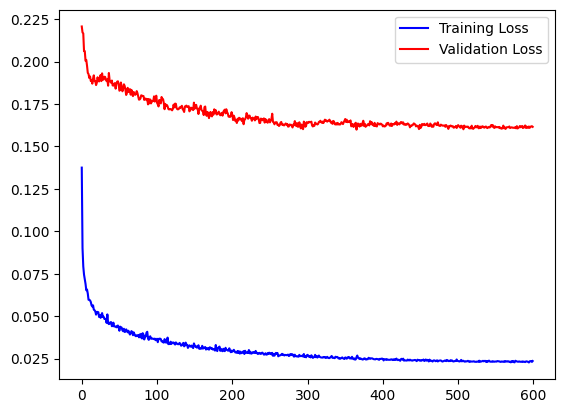

Average R² Score: 0.1729

Training combination 5/18
Parameters: lr=0.0001, hidden_size=512, num_hid_layers=4


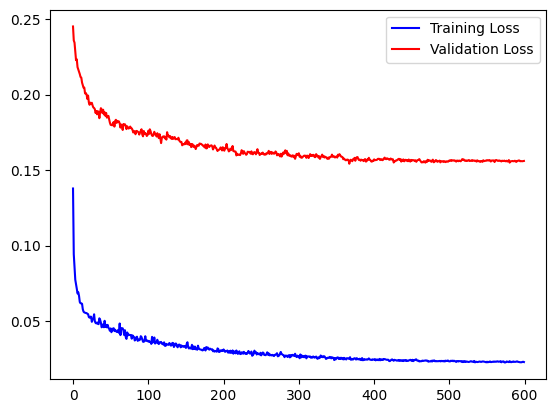

Average R² Score: 0.3354

Training combination 6/18
Parameters: lr=0.0001, hidden_size=512, num_hid_layers=5


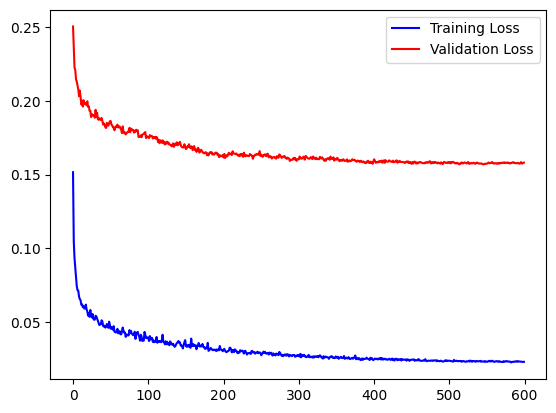

Average R² Score: 0.2220

Training combination 7/18
Parameters: lr=0.0001, hidden_size=1028, num_hid_layers=3


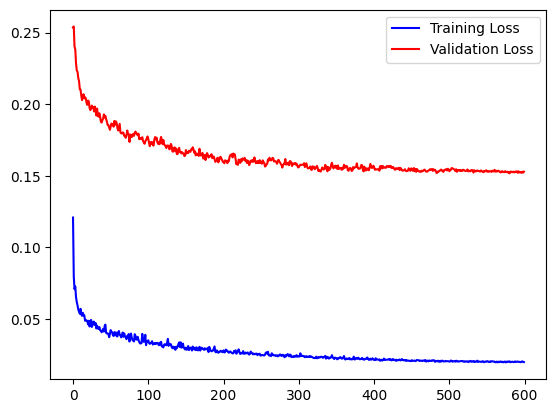

Average R² Score: 0.2677

Training combination 8/18
Parameters: lr=0.0001, hidden_size=1028, num_hid_layers=4


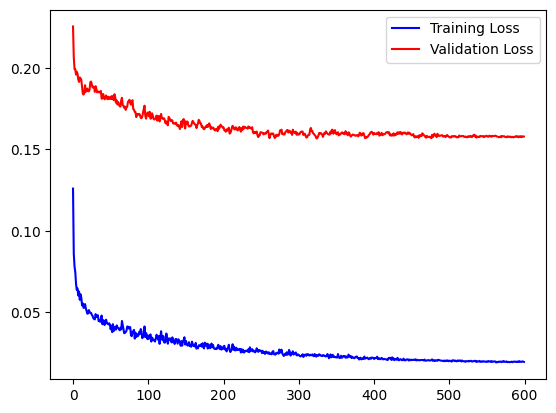

Average R² Score: 0.3595

Training combination 9/18
Parameters: lr=0.0001, hidden_size=1028, num_hid_layers=5


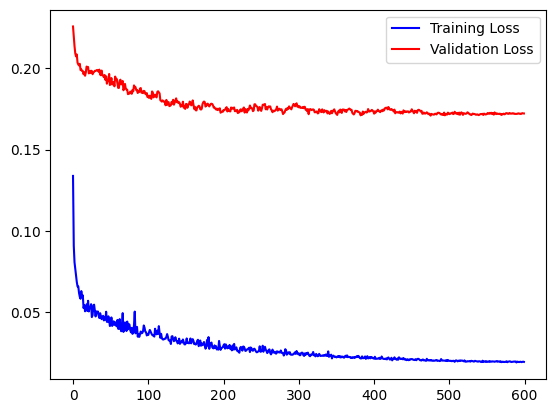

Average R² Score: 0.2043

Training combination 10/18
Parameters: lr=0.001, hidden_size=256, num_hid_layers=3


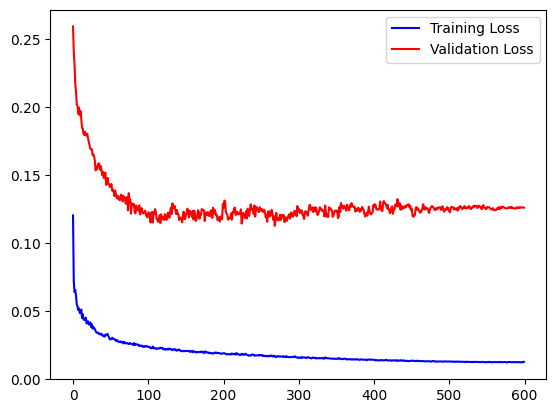

Average R² Score: 0.2547

Training combination 11/18
Parameters: lr=0.001, hidden_size=256, num_hid_layers=4


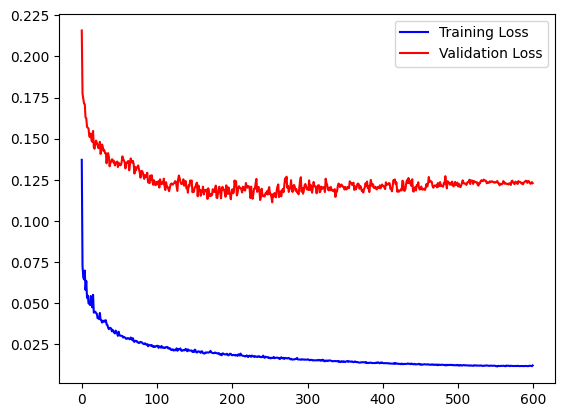

Average R² Score: 0.2617

Training combination 12/18
Parameters: lr=0.001, hidden_size=256, num_hid_layers=5


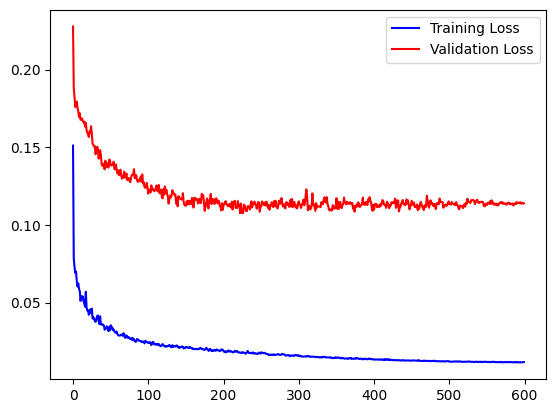

Average R² Score: 0.4637

Training combination 13/18
Parameters: lr=0.001, hidden_size=512, num_hid_layers=3


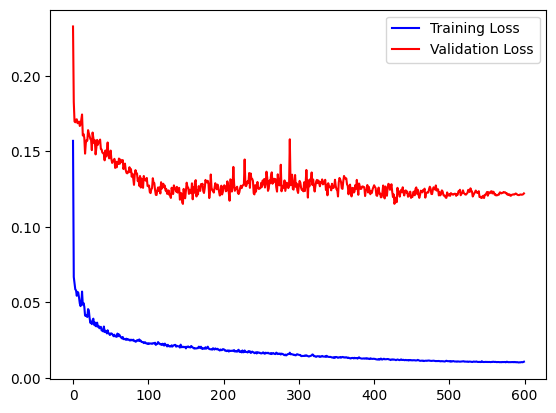

Average R² Score: 0.1126

Training combination 14/18
Parameters: lr=0.001, hidden_size=512, num_hid_layers=4


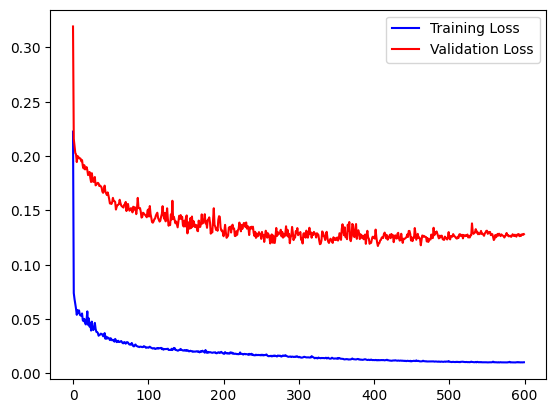

Average R² Score: 0.3439

Training combination 15/18
Parameters: lr=0.001, hidden_size=512, num_hid_layers=5


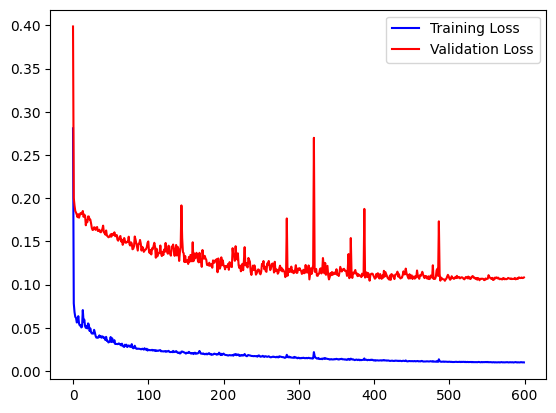

Average R² Score: 0.4704

Training combination 16/18
Parameters: lr=0.001, hidden_size=1028, num_hid_layers=3


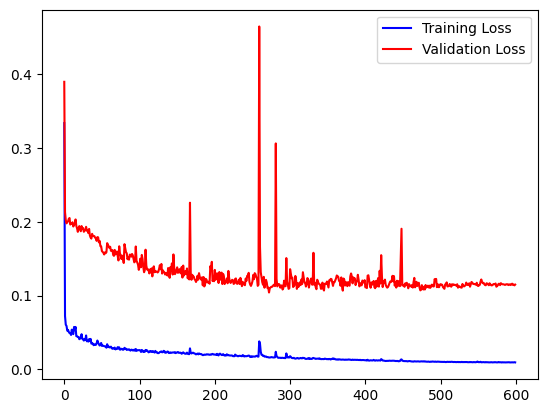

Average R² Score: 0.4605

Training combination 17/18
Parameters: lr=0.001, hidden_size=1028, num_hid_layers=4


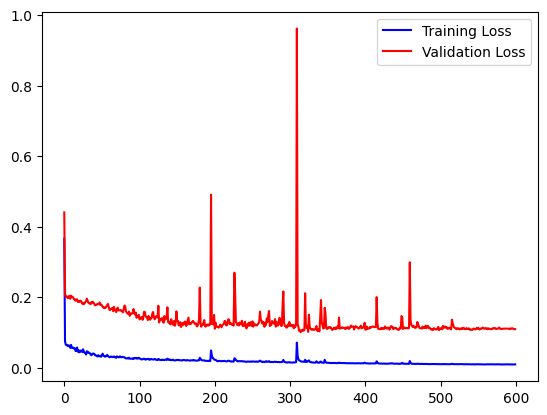

Average R² Score: 0.4147

Training combination 18/18
Parameters: lr=0.001, hidden_size=1028, num_hid_layers=5


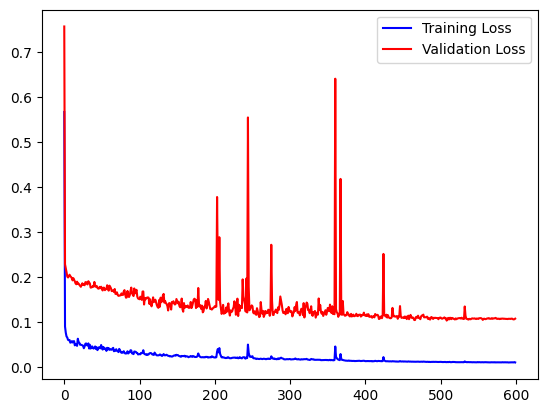

Average R² Score: 0.4309



Best Model Results

Parameters:
learning_rate: 0.001
hidden_size: 512
num_hid_layers: 5

Average R² Score: 0.4704

R² Scores by Sector:
HealthCare: 0.7491
Materials: 0.6823
Industrials: 0.6754
ConsumerStaples: -0.1488
ConsumerDiscretionary: 0.8334
Utilities: 0.0309


In [ ]:
param_grid = {
    'learning_rate': [1e-4, 1e-3],
    'hidden_size': [256, 512, 1028],
    'num_hid_layers': [3, 4, 5]
}

sectors = ['HealthCare', 'Materials', 'Industrials', 'ConsumerStaples', 'ConsumerDiscretionary', 'Utilities']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = xtr.shape[1]  # Number of features in input data

combinations = list(product(
    param_grid['learning_rate'],
    param_grid['hidden_size'],
    param_grid['num_hid_layers']
))



# Function to train model and get R2 scores
def train_and_evaluate(learning_rate, hidden_size, num_hid_layers, xtr, ytr, xval, yval, input_size, device, sectors, max_steps=30000, batch_size=128):

    model = Net(input_size, hidden_size=hidden_size, num_hid_layers=num_hid_layers)
    model.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
    criterion = nn.MSELoss()
    scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=(max_steps/1000))

    # Training loop
    losses = []
    val_losses = []
    for step in range(max_steps):
        model.train()
        ix = torch.randint(0, xtr.shape[0], (batch_size,))
        xb, yb = xtr[ix], ytr[ix]
        xb, yb = xb.to(device), yb.to(device)

        pred = model(xb)
        loss = criterion(pred, yb)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if step % 1000 == 0 and step != 0:
            scheduler.step()

        # Evaluate
        model.eval()
        with torch.no_grad():
            xval, yval = xval.to(device), yval.to(device)
            pred = model.predict(xval)
            lossval = criterion(pred, yval).item()
            val_losses.append(lossval)
            pred = pred.cpu()
            yval = yval.cpu()

    pred_np = pred.numpy()[::-1]
    yval_np = yval.numpy()[::-1]

    r2_scores = {}
    for i in range(6):
        r2 = r2_score(yval_np[:, i], pred_np[:, i])
        r2_scores[sectors[i]] = r2

    # Calculate average R2 score
    avg_r2 = sum(r2_scores.values()) / len(r2_scores)

    graph_losses = [np.mean(losses[i:i+50])**(1/2) for i in range(0, len(losses), 50)]
    graph_val_losses = [np.mean(val_losses[i:i+50])**(1/2) for i in range(0, len(val_losses), 50)]
    plt.plot(graph_losses, color='blue', label='Training Loss')
    plt.plot(graph_val_losses, color='red', label='Validation Loss')
    plt.legend()
    plt.show()

    return r2_scores, avg_r2, model

# Run grid search
best_avg_r2 = -float('inf')
best_model = None
best_scores = None
best_params = None

for i, (lr, hs, layers) in enumerate(combinations):
    print(f"\nTraining combination {i+1}/{len(combinations)}")
    print(f"Parameters: lr={lr}, hidden_size={hs}, num_hid_layers={layers}")

    r2_scores, avg_r2, model = train_and_evaluate(
        learning_rate=lr,
        hidden_size=hs,
        num_hid_layers=layers,
        xtr=xtr,
        ytr=ytr,
        xval=xval,
        yval=yval,
        input_size=input_size,
        device=device,
        sectors=sectors
    )

    print(f"Average R² Score: {avg_r2:.4f}")

    if avg_r2 > best_avg_r2:
        best_avg_r2 = avg_r2
        best_scores = r2_scores
        best_params = {
            'learning_rate': lr,
            'hidden_size': hs,
            'num_hid_layers': layers
        }
        best_model = model

# Print results for the best model
print("\n\n\nBest Model Results")
print("\nParameters:")
for param, value in best_params.items():
    print(f"{param}: {value}")
print(f"\nAverage R² Score: {best_avg_r2:.4f}")
print("\nR² Scores by Sector:")
for sector, score in best_scores.items():
    print(f"{sector}: {score:.4f}")


# Prediction on Validation Data

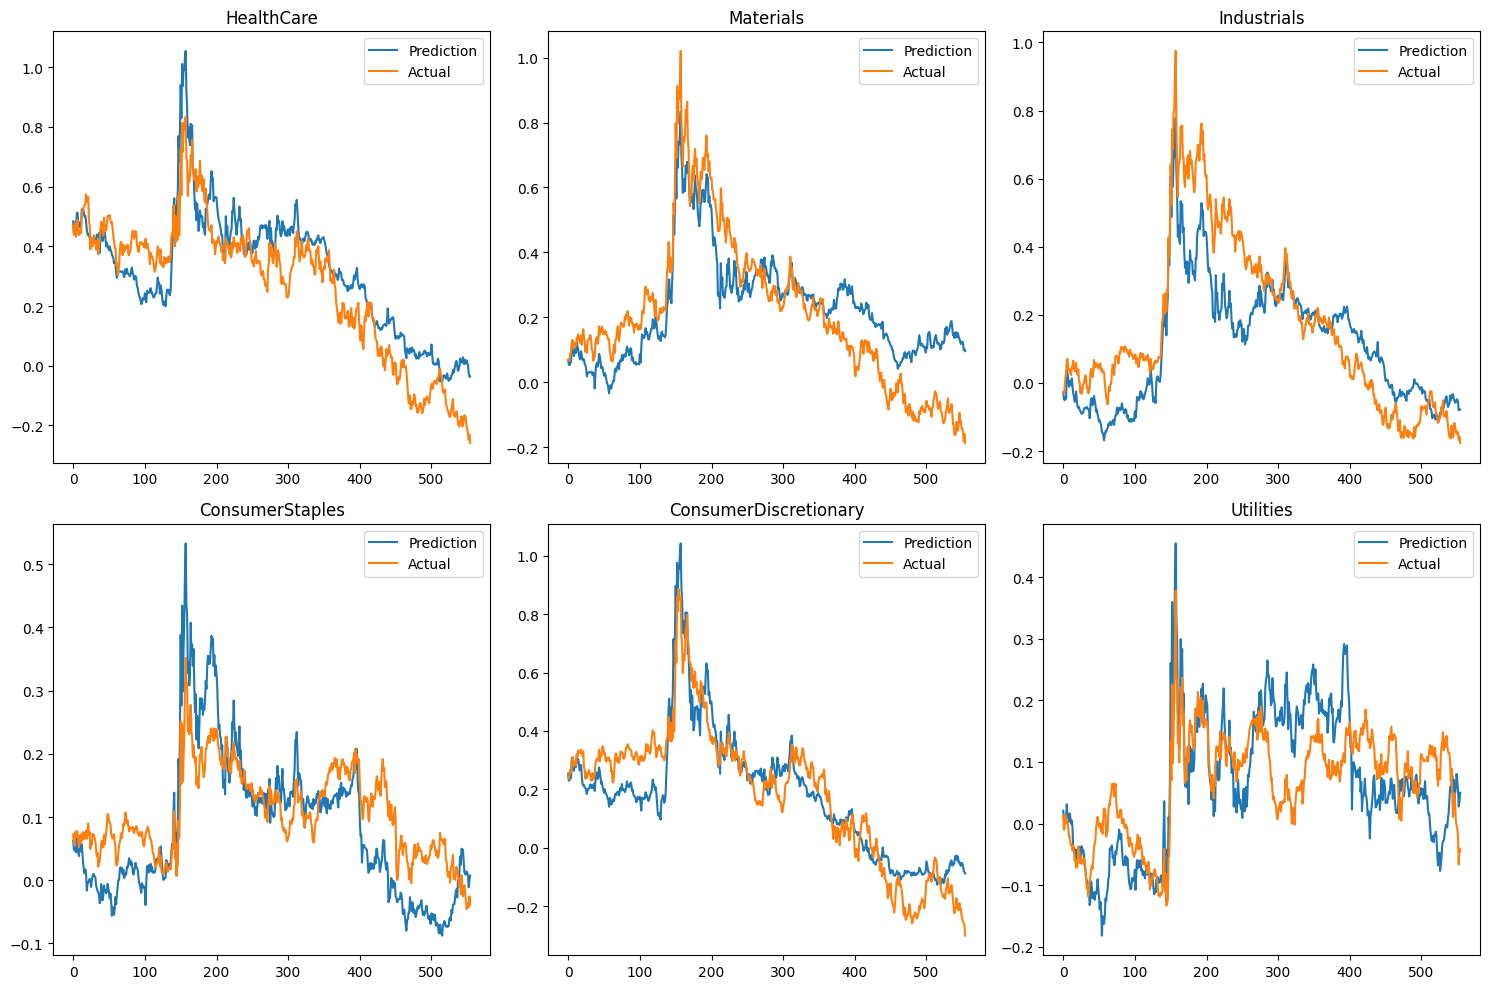

R² Scores for Each Sector:
HealthCare: 0.7491
Materials: 0.6823
Industrials: 0.6754
ConsumerStaples: -0.1488
ConsumerDiscretionary: 0.8334
Utilities: 0.0309


In [16]:
best_model.eval()
with torch.no_grad():
    xval = xval.to(device)
    pred = best_model.predict(xval)
    pred = pred.cpu()
pred_np = pred.numpy()[::-1]
yval_np = yval.numpy()[::-1]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes = axes.flatten()

r2_scores = {}

for i in range(6):

    r2 = r2_score(yval_np[:, i], pred_np[:, i])
    r2_scores[sectors[i]] = r2

    ax = axes[i]
    ax.plot(pred_np[:, i], label=f'Prediction')
    ax.plot(yval_np[:, i], label=f'Actual')
    ax.set_title(sectors[i])
    ax.legend()

plt.tight_layout()
plt.show()

print("R² Scores for Each Sector:")
for sector, score in r2_scores.items():
    print(f"{sector}: {score:.4f}")

# Prediction on Testing Data

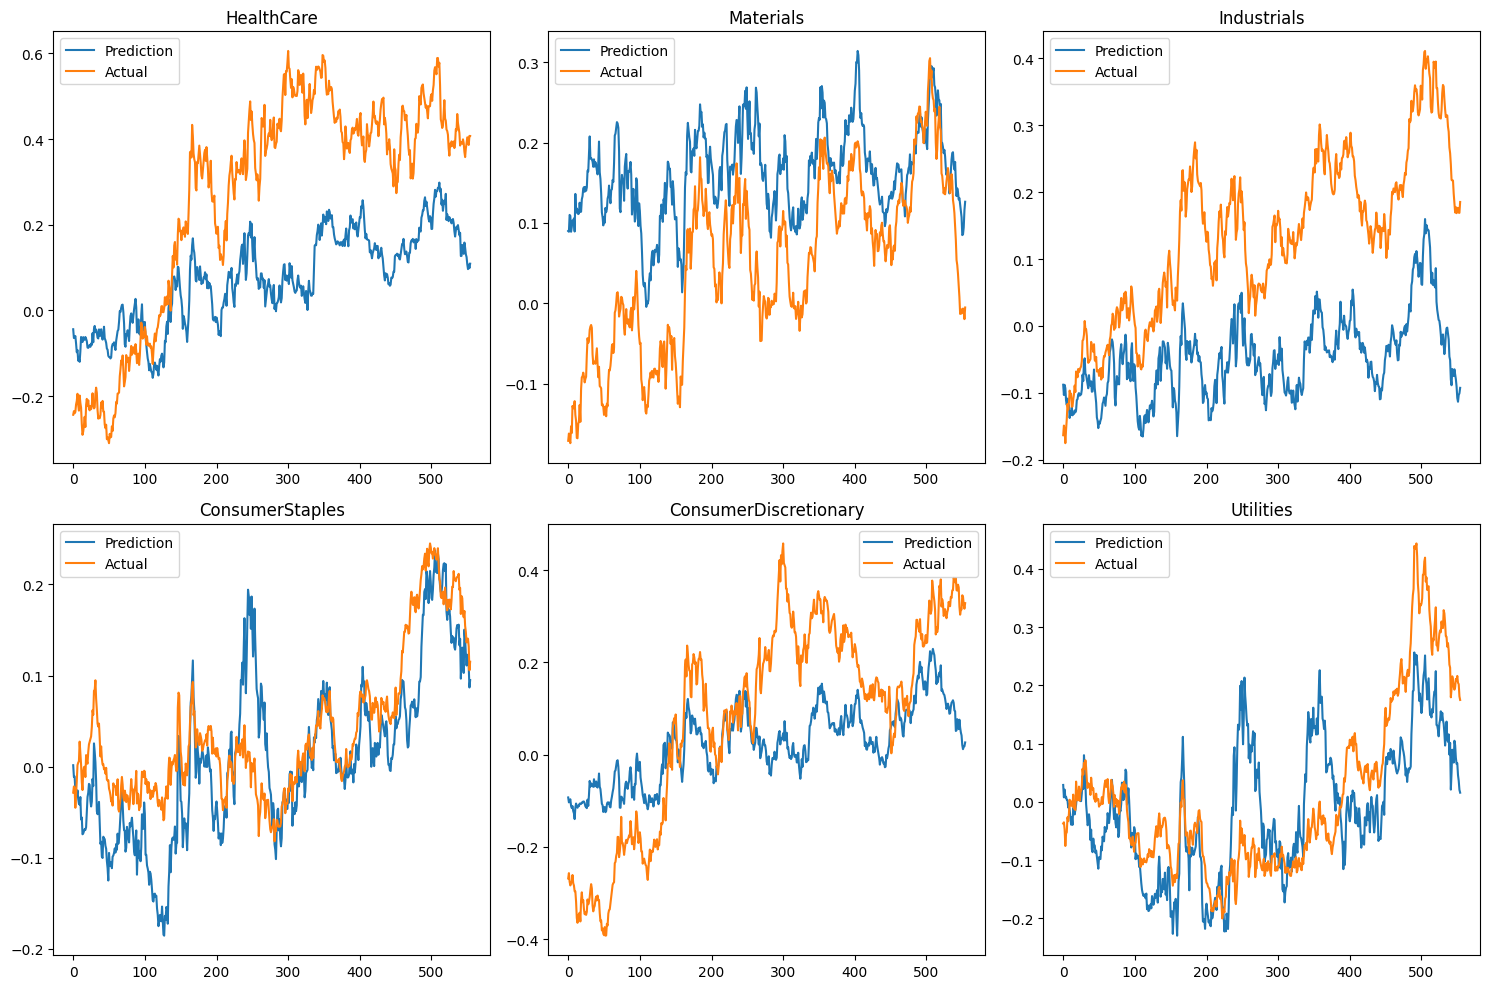

R² Scores for Each Sector:
HealthCare: -0.0274
Materials: -0.6378
Industrials: -1.6268
ConsumerStaples: 0.3602
ConsumerDiscretionary: 0.3834
Utilities: 0.4181


In [ ]:
best_model.eval()
with torch.no_grad():
    xte = xte.to(device)
    pred = best_model.predict(xte)
    pred = pred.cpu()
pred_np = pred.numpy()[::-1]
yte_np = yte.numpy()[::-1]

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

axes = axes.flatten()

r2_scores = {}

for i in range(6):

    r2 = r2_score(yte_np[:, i], pred_np[:, i])
    r2_scores[sectors[i]] = r2

    ax = axes[i]
    ax.plot(pred_np[:, i], label=f'Prediction')
    ax.plot(yte_np[:, i], label=f'Actual')
    ax.set_title(sectors[i])
    ax.legend()

plt.tight_layout()
plt.show()

print("R² Scores for Each Sector:")
for sector, score in r2_scores.items():
    print(f"{sector}: {score:.4f}")
